In [1]:
import tensorflow as tf
import numpy as np
import vgg19
import matplotlib.pyplot as plt
import utils

In [2]:
#img = tf.placeholder(tf.float32, [None, 224, 224, 3])
i_max = 2

device = '/cpu:0'
show = True

In [3]:
def gram_matrix(F, N, M):
    Ft = tf.reshape(F, (M, N))
    return tf.matmul(tf.transpose(Ft), Ft)

In [4]:
def main_loss_function(x):
    return

In [5]:
def create_noise_image(width, height):
    image = np.random.uniform(-32,32, (1, height, width, 3)).astype('float32')
    
    if(show == True):
        plt.imshow(image.reshape(height,width,3))
        plt.show()
    return image

In [6]:
def get_image(path):
    #load image
    img_input = utils.load_image(path)
    img = img_input.reshape((1, 224, 224, 3))
    
    #show image
    if(show == True):
        plt.imshow(img_input.reshape((224,224,3)))
        plt.show()
        
    return img

In [7]:
def get_layers(image):            
    #vgg
    vgg = vgg19.Vgg19()
    with tf.name_scope("content_vgg"):
        vgg.build(image)

    layers = [vgg.pool4, vgg.pool3, vgg.pool2, vgg.pool1, vgg.conv1_1]
    
    return layers

In [8]:
def get_gram_loss(target_layers, input_layers):
    gram_losses = []
    #go through layers
    for tl, il in zip(target_layers, input_layers):
        #get dimensions
        dimensions = tl.get_shape().as_list()
        size = dimensions[3]*dimensions[2]*dimensions[1]
        
        #get gram
        target_gram = gram_matrix(tl, dimensions[3], dimensions[2]*dimensions[1])
        input_gram = gram_matrix(il, dimensions[3], dimensions[2]*dimensions[1])
        
        #get losses
        gram_losses.append(2 * tf.nn.l2_loss(target_gram - input_gram) / size)
    
    #get gram_loss
    gram_loss = tf.reduce_sum(gram_losses)
    
    return gram_loss

In [9]:
def get_loss(target_layers, input_layers):
    loss = 0
    losses = []
    
    #gram loss
    gram_loss = get_gram_loss(target_layers, input_layers) 
    
    
    #get histogram matrices
    
    
    

    return gram_loss

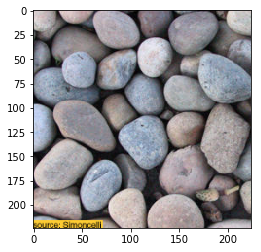

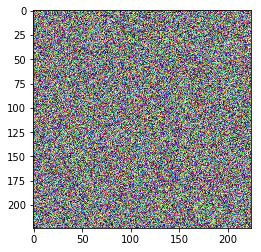

/home/rwjoverwater/in4015/vgg19.npy
npy file loaded
build model started
build model finished: 0s
/home/rwjoverwater/in4015/vgg19.npy
npy file loaded
build model started
build model finished: 0s


In [10]:
with tf.device(device):
    sess = tf.InteractiveSession()
    
    #placeholders
    input_image = tf.placeholder(tf.float32, [1, 224, 224, 3])
    target_image = tf.placeholder(tf.float32, [1, 224, 224, 3])
    
    #load style image
    input_img = get_image("./test_data/pebbles.jpg")
    #create target image
    target_img = (create_noise_image(224, 224))
        
    #fill feed dictionary
    feed_dict = {input_image: input_img, target_image: target_img}
                 
    #create variables                 
    target = tf.Variable(target_img)
            
    #input vgg
    style_layers = get_layers(input_image)
    #target vgg
    target_layers = get_layers(target_image)
    
    #get losses
    loss = get_loss(target_layers, style_layers)
    


In [ ]:
    #init
    sess.run(tf.global_variables_initializer(), feed_dict=feed_dict)
    
    #summary_writer = tf.summary.FileWriter('./logs', graph=tf.get_default_graph())
    #summary_writer.flush()
    #summary_writer.close()
    
    sess.run(target.assign(target_image))
     
    #handlers
    optimizer = tf.train.AdamOptimizer(0.5)
    minimize = optimizer.minimize(loss)

In [ ]:
    for i in range(i_max):

        #optimize step
        sess.run(minimize)
        
        #print loss
        print(sess.run(loss))
        
        
        #show image
        if(show == True):
            plt.imshow(target_img.reshape((224,224,3)))
            plt.show()
